In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
dsA = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionA_mixed.zarr')
dsB = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/vels_regionB_mixed.zarr')

lonsa, latsa = np.meshgrid(dsA.x0.values, dsA.y0.values)
lonsb, latsb = np.meshgrid(dsB.x0.values, dsB.y0.values)

In [3]:
def target_area_def_a(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def target_area_def_b(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =17,40#center_point.x0.values.item(),-center_point.y0.values.item()#region b:3,32 # region c: 17,40
    #region a: center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def


def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 0, 1))

def ufunc_resample_a(data):
    target_def = target_area_def_a(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsa, lats=-latsa)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

def ufunc_resample_b(data):
    target_def = target_area_def_a(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsb, lats=-latsb)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

In [4]:
u_resampled_unfilta = ufunc_resample_a(dsA.unfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_unfilta = ufunc_resample_a(dsA.unfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_lagfilta = ufunc_resample_a(dsA.lagfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_lagfilta = ufunc_resample_a(dsA.lagfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_eulfilta = ufunc_resample_a(dsA.eulfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_eulfilta = ufunc_resample_a(dsA.eulfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [5]:
u_resampled_unfiltb = ufunc_resample_b(dsB.unfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_unfiltb = ufunc_resample_b(dsB.unfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_lagfiltb = ufunc_resample_b(dsB.lagfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_lagfiltb = ufunc_resample_b(dsB.lagfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

u_resampled_eulfiltb = ufunc_resample_b(dsB.eulfiltered_u.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())
v_resampled_eulfiltb = ufunc_resample_b(dsB.eulfiltered_v.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

fronto_resampled_a = ufunc_resample_a(dsA.frontogenesis.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

fronto_resampled_b = ufunc_resample_b(dsB.frontogenesis.swap_dims({"i": "x0"}).swap_dims({"j": "y0"}).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [6]:
tangrida = Grid(u_resampled_unfilta, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})

tangridb = Grid(u_resampled_unfiltb, coords={'X': {'center': 'x1', 'left': 'x1_g'}, 'Y': {'center': 'y1', 'left': 'y1_g'}})


In [7]:
div_unfiltA = (tangrida.interp(tangrida.diff(u_resampled_unfilta,'X'),'X')+tangrida.interp(tangrida.diff(v_resampled_unfilta,'Y'),'Y'))/1000
div_eulfiltA = (tangrida.interp(tangrida.diff(u_resampled_eulfilta,'X'),'X')+tangrida.interp(tangrida.diff(v_resampled_eulfilta,'Y'),'Y'))/1000
div_filtA = (tangrida.interp(tangrida.diff(u_resampled_lagfilta,'X'),'X')+tangrida.interp(tangrida.diff(v_resampled_eulfilta,'Y'),'Y'))/1000
div_wnfiltA = (tangrida.interp(tangrida.diff(dsA.wnfiltered_u,'X'),'X')+tangrida.interp(tangrida.diff(dsA.wnfiltered_v,'Y'),'Y'))/1000

div_unfiltB = (tangridb.interp(tangridb.diff(u_resampled_unfiltb,'X'),'X')+tangridb.interp(tangridb.diff(v_resampled_unfiltb,'Y'),'Y'))/1000
div_eulfiltB = (tangridb.interp(tangridb.diff(u_resampled_eulfiltb,'X'),'X')+tangridb.interp(tangridb.diff(v_resampled_eulfiltb,'Y'),'Y'))/1000
div_filtB = (tangridb.interp(tangridb.diff(u_resampled_lagfiltb,'X'),'X')+tangridb.interp(tangridb.diff(v_resampled_lagfiltb,'Y'),'Y'))/1000
div_wnfiltB = (tangridb.interp(tangridb.diff(dsB.wnfiltered_u,'X'),'X')+tangridb.interp(tangridb.diff(dsB.wnfiltered_v,'Y'),'Y'))/1000

windows,_ = xrft.xrft._apply_window(u_resampled_unfilta.drop_vars('time'), dims=['x1','y1','time'],window_type='tukey')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))


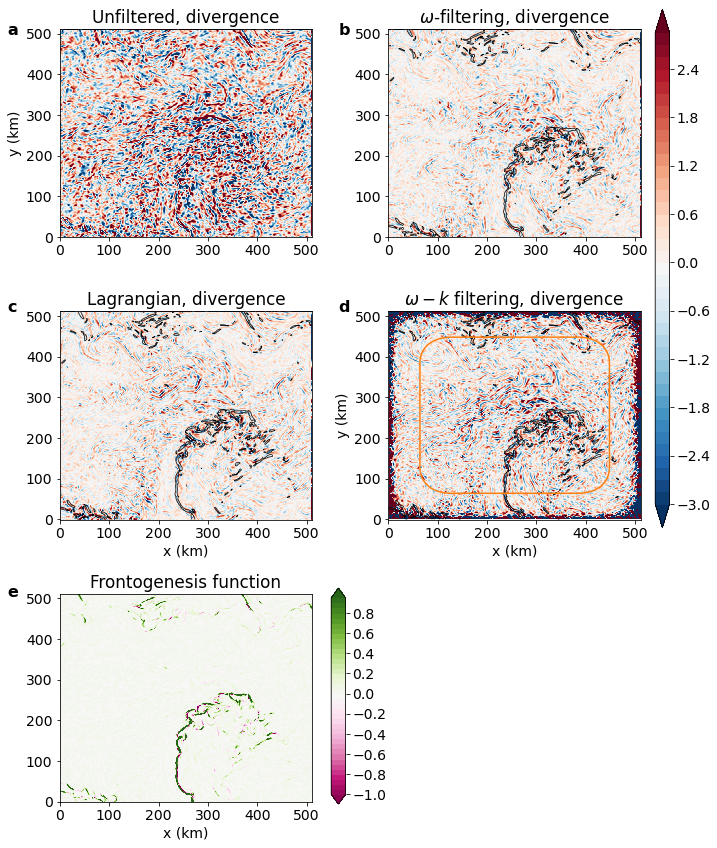

In [31]:
tt=35
fig=plt.figure(figsize=(10, 12))

plt.subplot(321)
(div_unfiltA*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
plt.title('Unfiltered, divergence')
plt.ylabel('y (km)')
plt.xlabel('')

plt.gcf().text(0.02, 0.95, 'a', fontsize = 16,fontweight='bold')

plt.subplot(322)
(div_eulfiltA*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
(fronto_resampled_a*10**14).isel(time=tt).plot.contour(
    levels=[-10, 0.2],add_colorbar=False,colors='k',linewidths=0.7)
plt.ylabel('')
plt.xlabel('')
plt.title('$\omega$-filtering, divergence')

plt.gcf().text(0.48, 0.95, 'b', fontsize = 16,fontweight='bold')

plt.subplot(323)
(div_filtA*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
(fronto_resampled_a*10**14).isel(time=tt).plot.contour(
    levels=[-10, 0.2],add_colorbar=False,colors='k',linewidths=0.7)
plt.ylabel('')
plt.title('Lagrangian, divergence')
plt.ylabel('')
plt.xlabel('x (km)')

plt.gcf().text(0.02, 0.63, 'c', fontsize = 16,fontweight='bold')

plt.subplot(324)
cs=(div_wnfiltA*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,rasterized=True)
(fronto_resampled_a*10**14).isel(time=tt).plot.contour(
    levels=[-10, 0.2],add_colorbar=False,colors='k',linewidths=0.7)

windows.isel(time=35).plot.contour(levels=[-10,0.5],colors='tab:orange')
plt.ylabel('')
plt.title('$\omega-k$ filtering, divergence')
plt.ylabel('y (km)')
plt.xlabel('x (km)')

plt.gcf().text(0.48, 0.63, 'd', fontsize = 16,fontweight='bold')

    
plt.subplot(325)
cs2 = (fronto_resampled_a*10**14).isel(time=tt).plot(levels=np.arange(-1,1,0.05),add_colorbar=False,cmap='PiYG',rasterized=True)
plt.ylabel('')
plt.xlabel('x (km)')
plt.title('Frontogenesis function')

plt.tight_layout()

plt.gcf().text(0.02, 0.3, 'e', fontsize = 16,fontweight='bold')

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.38, 0.02, 0.6])
fig.colorbar(cs, cax=cbar_ax,extend='both')

cbar_ax = fig.add_axes([0.47, 0.06, 0.02, 0.25])
fig.colorbar(cs2, cax=cbar_ax,extend='both')
fig.savefig("divergence_region_A.png",dpi=200)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in subtract
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))


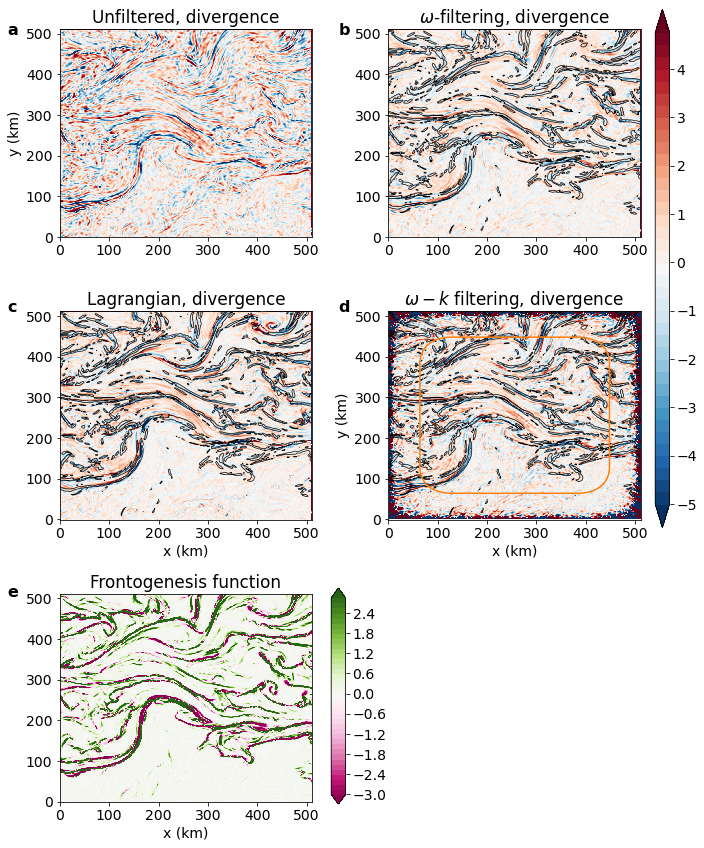

In [32]:
tt=35
fig=plt.figure(figsize=(10, 12))

plt.subplot(321)
(div_unfiltB*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
plt.title('Unfiltered, divergence')
plt.ylabel('y (km)')
plt.xlabel('')

plt.gcf().text(0.02, 0.95, 'a', fontsize = 16,fontweight='bold')

plt.subplot(322)
(div_eulfiltB*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
(fronto_resampled_b*10**14).isel(time=tt).plot.contour(
    levels=[-100, 1],add_colorbar=False,colors='k',linewidths=0.7)
plt.ylabel('')
plt.xlabel('')
plt.title('$\omega$-filtering, divergence')

plt.gcf().text(0.48, 0.95, 'b', fontsize = 16,fontweight='bold')

plt.subplot(323)
(div_filtB*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
(fronto_resampled_b*10**14).isel(time=tt).plot.contour(
    levels=[-100, 1],add_colorbar=False,colors='k',linewidths=0.7)
plt.ylabel('')
plt.title('Lagrangian, divergence')
plt.ylabel('')
plt.xlabel('x (km)')

plt.gcf().text(0.02, 0.63, 'c', fontsize = 16,fontweight='bold')

plt.subplot(324)
cs=(div_wnfiltB*10**5).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*5,add_colorbar=False,rasterized=True)
(fronto_resampled_b*10**14).isel(time=tt).plot.contour(
    levels=[-100, 1],add_colorbar=False,colors='k',linewidths=0.7)
windows.isel(time=35).plot.contour(levels=[-10,0.5],colors='tab:orange')
plt.ylabel('')
plt.title('$\omega-k$ filtering, divergence')
plt.ylabel('y (km)')
plt.xlabel('x (km)')

plt.gcf().text(0.48, 0.63, 'd', fontsize = 16,fontweight='bold')
    
plt.subplot(325)
cs2 = (fronto_resampled_b*10**14).isel(time=tt).plot(levels=np.arange(-1,1,0.05)*3,add_colorbar=False,cmap='PiYG',rasterized=True)
plt.ylabel('')
plt.xlabel('x (km)')
plt.title('Frontogenesis function')

plt.gcf().text(0.02, 0.3, 'e', fontsize = 16,fontweight='bold')

plt.tight_layout()

fig.subplots_adjust(right=0.9,wspace=0.3)
cbar_ax = fig.add_axes([0.92, 0.38, 0.02, 0.6])
fig.colorbar(cs, cax=cbar_ax,extend='both')

cbar_ax = fig.add_axes([0.47, 0.06, 0.02, 0.25])
fig.colorbar(cs2, cax=cbar_ax,extend='both')
fig.savefig("divergence_region_B.png",dpi=200)